In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

import sys
sys.path.insert(1, '../scripts/')
# import eda_tools as et
import data_munging_tools as dmt

In [2]:
#specify columns for plotting
ip_day =  180
target_col = f"production_liquid_{ip_day}"
coord_cols = ["surface_lat", "surface_lng", "bh_lat", "bh_lng"]
target_units ="bbls"
cat_cols = ["originaloperator", "countyname", "stimulated_formation"]
cat_col = cat_cols[2]
tooltip_features = ["currentwellname", cat_col]

In [3]:
foi = ['currentwellname',
       'originaloperator',
#        'countyname',
       'tvd',
       'length',
       'prop_per_ft',
       'fluid_per_ft',
       'stage_spacing',
       'countyname',
       'stimulated_formation']

In [4]:
inspect_df = (pd.read_csv("../data/cleaned-input.test.tsv", sep="\t").copy()
                      .rename(columns=str.lower)
                      .assign(api = lambda x: x["api"].str.strip("US"))
                      .set_index("api")
                      .sort_index(axis=1)
                      .assign(length=lambda x: dmt.haversine_distance(x["surface_lat"], 
                                                                      x["surface_lng"], 
                                                                      x["bh_lat"], 
                                                                      x["bh_lng"]),
                              prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                              fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                              stage_spacing=lambda x: x["total_num_stages"] / x["length"],
                              range_tvd=lambda x: x["max_tvd"] - x["min_tvd"]
                             )
                      .filter(foi + coord_cols)
                      .pipe(dmt.reduce_cardinality, cols=['originaloperator', 'countyname'])
             )

In [5]:
eval_df = (pd.read_csv("../results/eval_df.tsv", sep="\t", dtype={"api": "O"})
                 .set_index("api")
                 .join(inspect_df)
                 .assign(day=ip_day,
                         prod_rate=lambda x: x["actual"] / x["day"]
                        )
          )

In [6]:
def calculate_prediction_summary(df_group):
    summary_dict = {}
    summary_dict["num_obs"] = df_group.shape[0]
    summary_dict["avg_actual"] = df_group["actual"].mean()
    summary_dict["mae"] = df_group["abs_resid"].mean()
    summary_dict["mape"] = df_group["abs_perc_resid"].mean()
    summary_dict["med_ape"] = df_group["abs_perc_resid"].median()
    summary_dict["adj_mape"] = summary_dict["mae"] / summary_dict["avg_actual"] * 100
    return pd.Series(summary_dict)

In [7]:
def make_cat_scat_df(resids_df, gb_cols):
    error_summary_df = (resids_df.copy()
                        .groupby(gb_cols)
                        .apply(calculate_prediction_summary)
                        .apply(lambda x: x.round(1) if x.dtype == float else x)
                        .reset_index()
                        )
    return error_summary_df

In [8]:
def draw_cat_scat_plot(resids_df, cat_col, tooltip_features):
    
    size = [800, 800]

    resid_scatter = alt.Chart(resids_df, width=size[0], height=size[1]).mark_circle(size=100).encode(
        x=alt.X("actual:Q", title="Actual Value"),
        y=alt.Y("pred:Q", title="Prediction"),
        color=alt.Color(f'{cat_col}:N', legend=None),
        tooltip= tooltip_features
    ).properties(
        title=f"Prediction Residuals, colored by {cat_col}"
    ).interactive()

    
    max_val = resids_df["actual"].max()* 1.1
    identity_rule_df = pd.DataFrame([{"x": 0, "y": 0}, {"x": max_val, "y": max_val}])
    identity_rule = alt.Chart(identity_rule_df).mark_line(color="#000000").encode(
            x="x:Q",
            y='y:Q',
        )

    resid_scatter_ruled = (resid_scatter + identity_rule)
    
    return resid_scatter_ruled

In [9]:
def draw_cat_bars(cat_err_df):
    value_counts = alt.Chart(title=f"Value Counts, by {cat_col}", width=400, height=180).mark_bar().encode(
                        alt.Y(f'{cat_col}:N', title=""),
                        alt.X('num_obs:Q', title="Number of Observations"),
                        alt.Color(f'{cat_col}:N', legend=None)
                        )
                     
                     
    avg_actual = alt.Chart( width=400, height=180).mark_bar().encode(
                        alt.Y(f'{cat_col}:N', title=""),
                        alt.X('avg_actual:Q', title=target_units, stack=None),
                        alt.Color(f'{cat_col}:N', legend=None)
                    )
                     
    mae = alt.Chart(width=400, height=180, title="MAE(black) vs. Mean of Actual Values").mark_bar(color="black").encode(
                        alt.Y(f'{cat_col}:N'),
                        alt.X('mae:Q', axis=alt.Axis(title=target_units), title=target_units, stack=None),
                    )
                     
    avg_actual_vs_mae = avg_actual + mae

    adj_mape = alt.Chart(title="Adjusted MAPE", width=400, height=180).mark_bar().encode(
                        alt.Y(f'{cat_col}:N', title=""),
                        alt.X('adj_mape:Q', title="MAPE (percent)"),
                        alt.Color(f'{cat_col}:N', legend=None)
                        )

    bar_charts = alt.VConcatChart(data=cat_err_df, vconcat=(value_counts, avg_actual_vs_mae, adj_mape))
    
    return bar_charts

In [10]:
def draw_cat_resids_plots(resids_df, cat_col, tooltip_features):
    resids_df = resids_df.copy().fillna("Missing")
    categorical_scatterplot = draw_cat_scat_plot(resids_df, cat_col, tooltip_features)
    cat_err_df = make_cat_scat_df(resids_df, gb_cols=[cat_col])
    bar_charts = draw_cat_bars(cat_err_df)
    master_plot = alt.hconcat(categorical_scatterplot, bar_charts, center=True).configure_axis(labelFontSize=15, titleFontSize=14).configure_title(fontSize=18)
    return master_plot

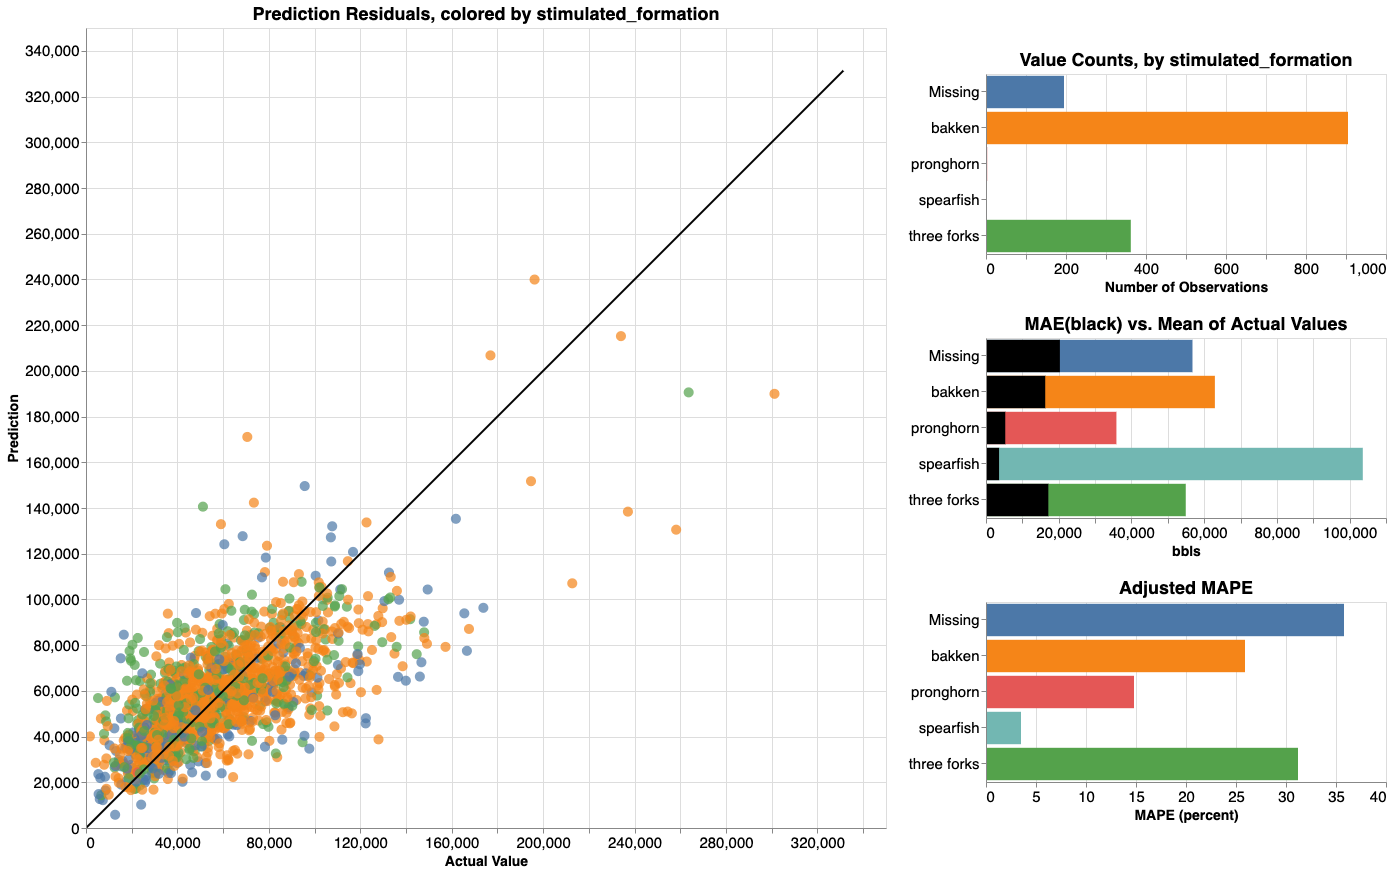

In [11]:
draw_cat_resids_plots(eval_df, cat_col, tooltip_features)